## HNSW (Heirarchical Navigable Small World)

Arguably state of art. Graph based method for approximate search, 


## Method

Based on two fundamental concepts -Probability skip lists, and Navigable small world graphs

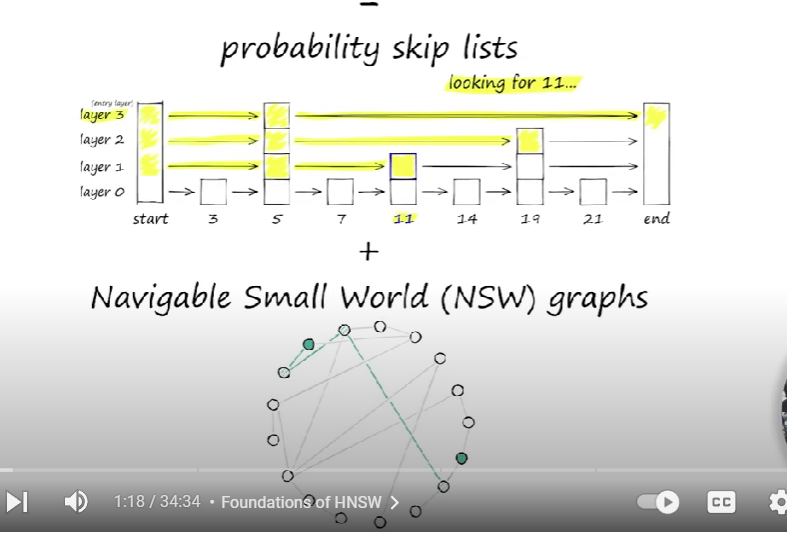

### Probability Skip lists

Uses layers of linked lists, bottom layer has all connections, and as you go towards the top, you get fewer and fewer connections (https://www.geeksforgeeks.org/skip-list/
More precisely, In a skip list, elements are organized in layers, with each layer having a smaller number of elements than the one below it. The bottom layer is a regular linked list, while the layers above it contain “skipping” links that allow for fast navigation to elements that are far apart in the bottom layer.

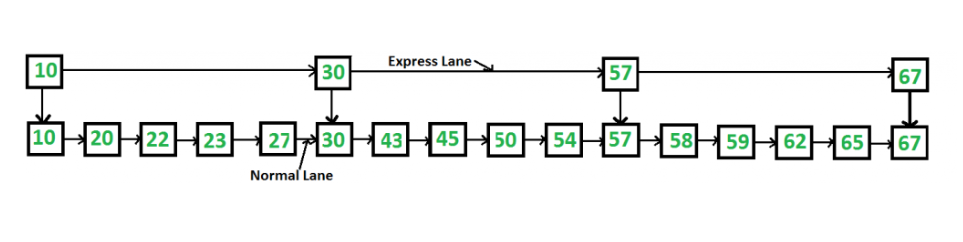



A skip list is a data structure that allows for efficient search, insertion and deletion of elements in a sorted list. It is a probabilistic data structure, meaning that its average time complexity is determined through a probabilistic analysis.


Where is probability used ? Right from insertion

Skip lists are implemented using a technique called “coin flipping.” In this technique, a random number is generated for each insertion to determine the number of layers the new element will occupy. This means that, on average, each element will be in log(n) layers, where n is the number of elements in the bottom layer.

For example, when inserting an element, you can

1)  Search for the element
2)  Flip a coin to determine how many levels the new element has to be inserted into
Let the height be zero with probability 1/2, one with probability 1/4, two with probability 1/8, etc.
3)  If the result is larger than the current height, create new levels




Alternatives are BST, and AVL/Red-black search trees, skip lists too have   O(log n) for search, insertion and deletion, which is similar to that of balanced trees, such as AVL trees and red-black trees, but with the advantage of simpler implementation and lower overhead.

### During search

Upper levels of the skip list serve as expressways since some elements are skipped during traversal.

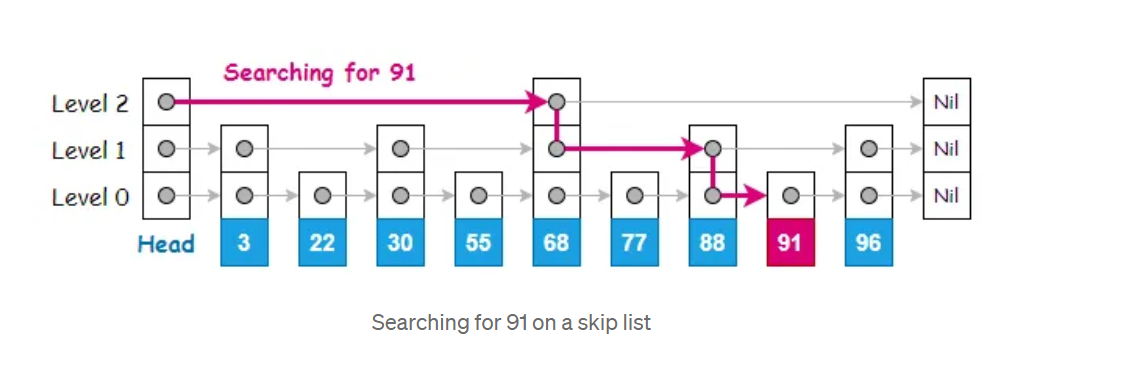

Searching for 91 on this requires just traversing 3 nodes/hops, whereas searching on the original linked list at the lowest level requires traversing 8 nodes/hops

## Navigable small world graphs (NSW) 

A navigable small world graph is a directed grid with additional long-range connections that are chosen randomly. The vertices in the graph are connected based on proximity, which reduces search time to logarithmic complexity.


If vectors are represented as vertices on a graph, logically, vertices that are close together (i.e. vectors with high similarity) should be connected as friends. Even if they’re not connected as friends, they should be reachable by each other easily by traversing just one or two other vertices


For a graph to be navigable, every vertex must have friends. Else there is no way to reach the vertex. Having friends is great, but having too many friends can be very costly for a graph. Just think of the memory and storage required to keep those connections and the number of computations needed to compare distances during search time.

So we need just the right no of friends on average, not too many, not too less

Thus, we DO NOT want a graph like this

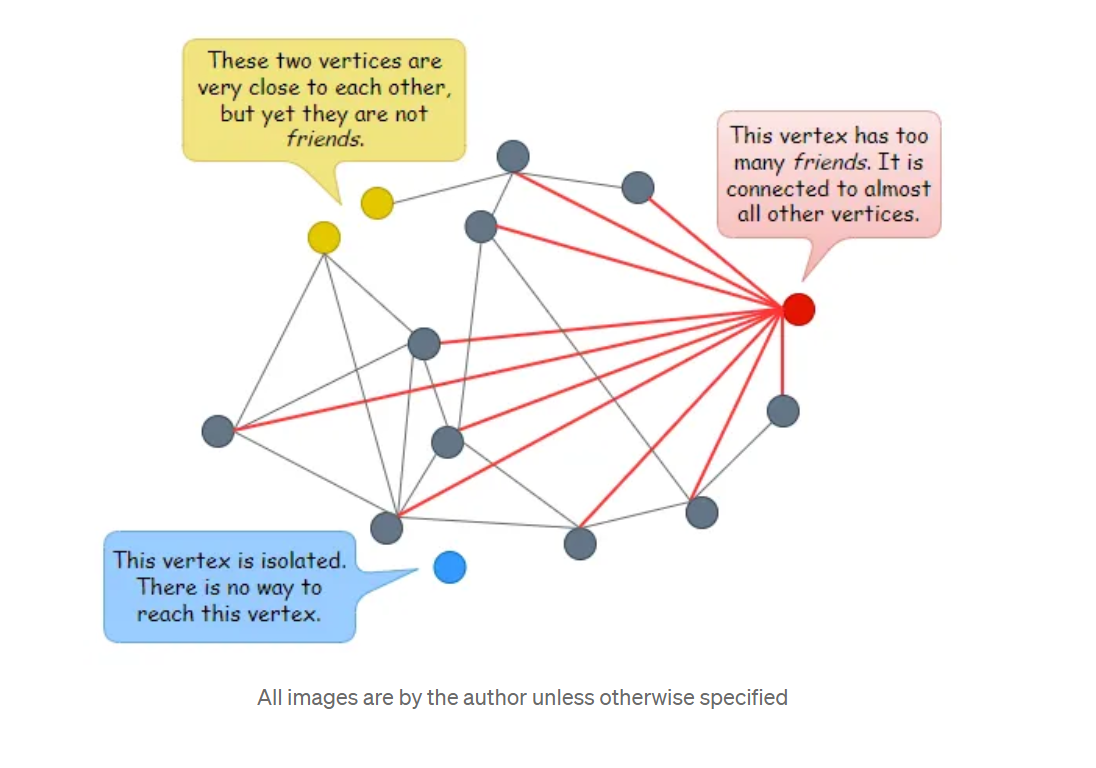

Where close vertices are not friends, some vertices have 0 edges (no friends and thus no way to reach them), some have too many friends

### NSW construction 

1)  Insert vertices one after another in random order (i.e. the vectors are first shuffled)
2) When a new vertex comes in, it will be connected to M vertices closest to it (M is a hyperparameter)
3) To be more concrete , assume you want to insert 5 vectors A,B,C,D,E, (after randomization) and M is 3
Start with A - no other vector initially, so insert A
Insert B, only one other Vector, so connect B to A
Insert C, connect C to B, C to A
Insert D, connect D to A, D to B, D to C
Now insert E. Let's say out of existing 4 vectors, E is closest to B,C,D (M=3). So connect E to B, E to C, E to D and so on


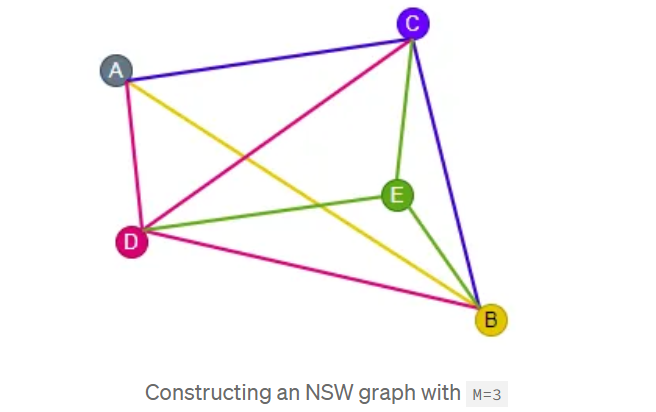



This process will eventually give a graph like this 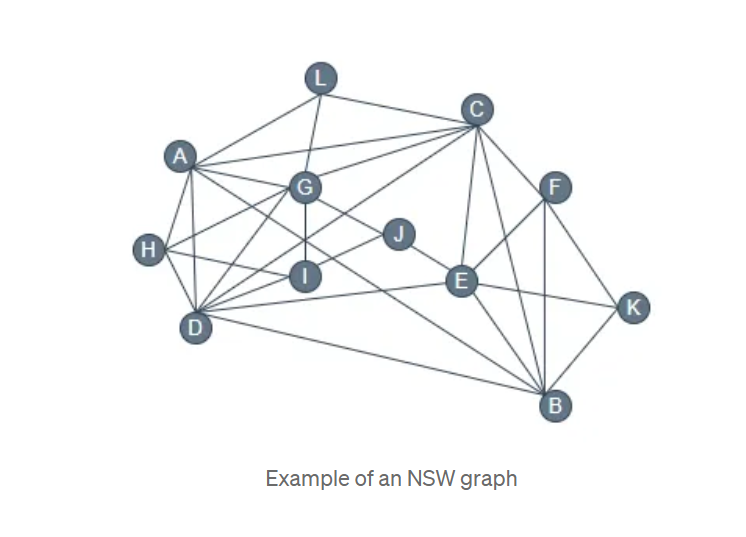

Where you see a mix of long and short range connections, specifically, some of the initial edges inserted like AB, etc have become long range




### NSW search

Greedy. can start from any vertex in the graph. no prior knowledge of dimensionality, distribution of data, etc required, just use the graph. 

0) New query vector comes in
1) Start with random entry point in the NSW graph
2) For the random entry point, pick a friend closest to the the query vector, and move towards that vector
3) Repeat 2) until you can now longer find a friend for a node closer than itself to the query vector

Example 1

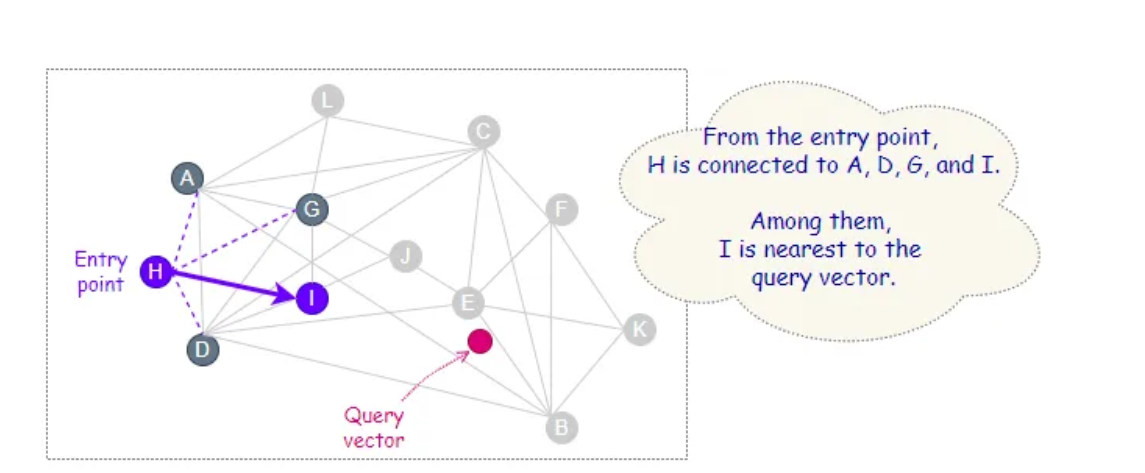

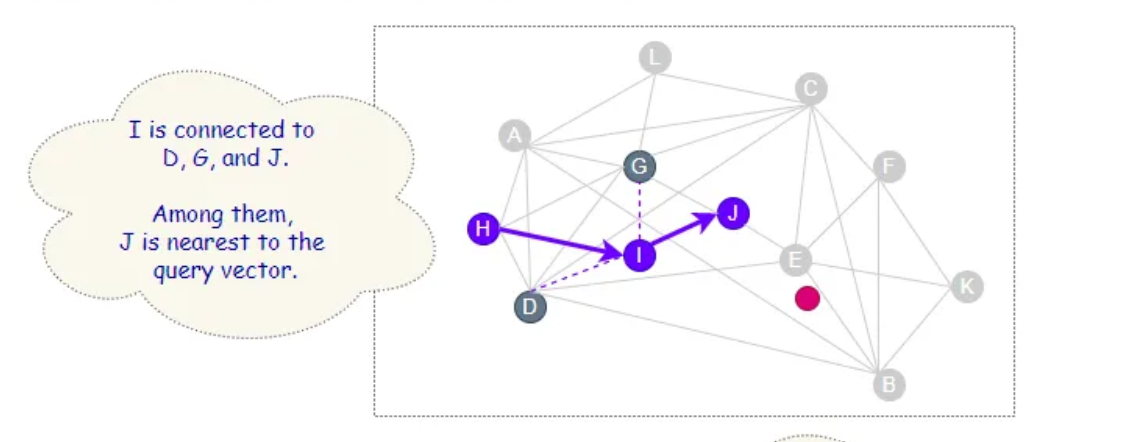


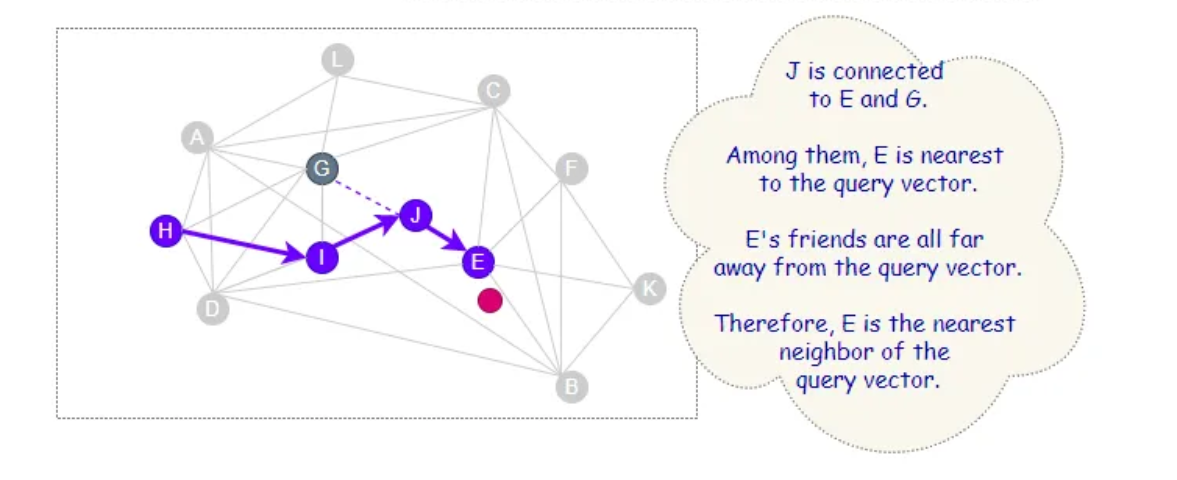

Example 2

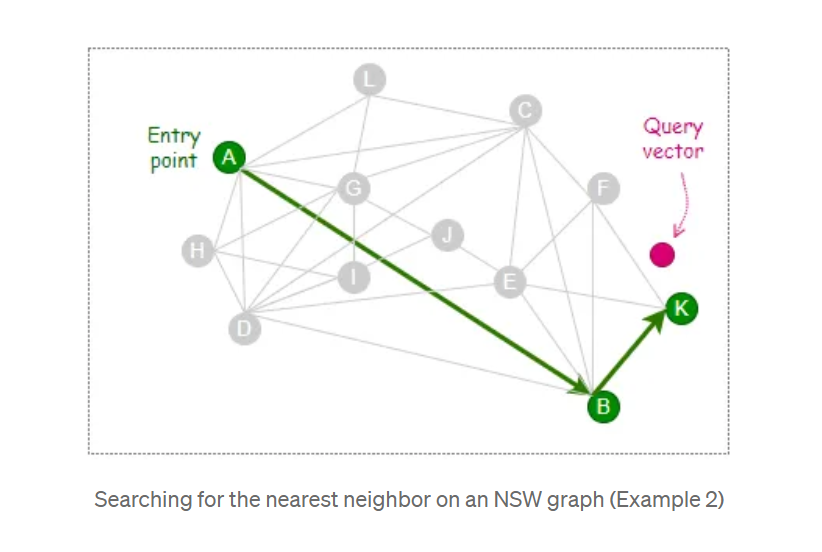


Note that the long range edge AB formed in early stages of construction helps traverse a long distance for this query in just two hops  A->B B->K




You can improve search quality by picking different entry points and repeating to find the closest node to the query vector

## HNSW 

Combines the principles of NSW and Skip List, where you can understand it as a Skip list , where instead of Linked lists at every level, you have NSW's at every level

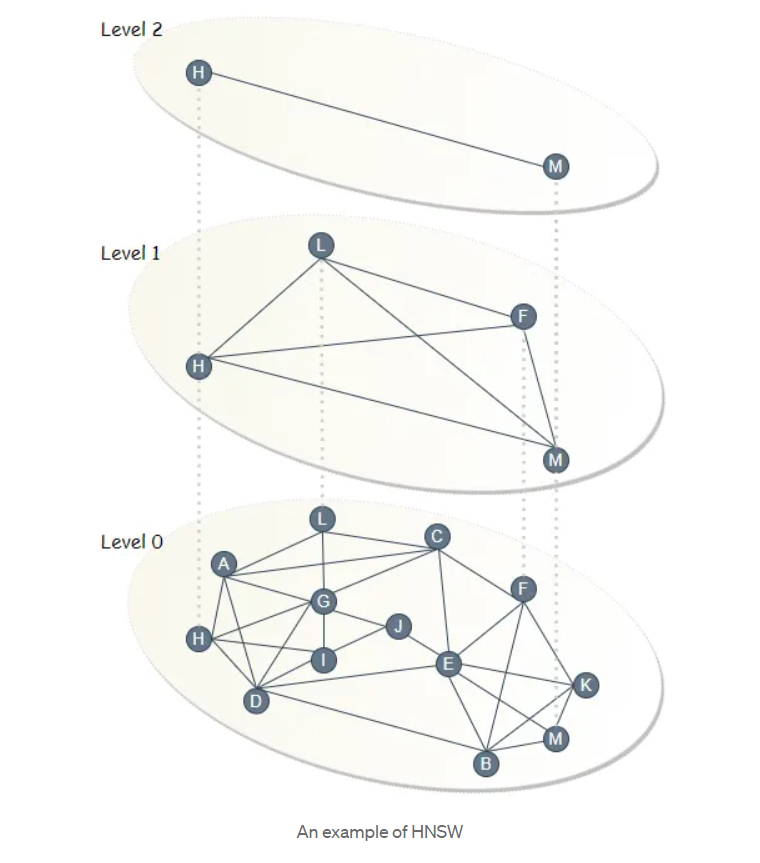

### HNSW construction 

1) Similar to NSW, in which the graph structure is also incrementally built by inserting vertices one after another

2) However, unlike NSW, you don't need to randomize initially, as the stochastic effect of HNSW is achieved by level randomization

3) Similar to skip list consturction, During graph construction for HNSW, each vertex is randomly assigned an integer, ℓ, indicating the maximum layer in which the vertex is present. For instance, if a vertex is assigned with ℓ=3, then we can find the vertex present at Level 2, Level 1, and Level 0. The maximum layer in which an element is present is selected randomly with an exponentially decaying probability distribution, ensuring that the top layer has lots of skip connections, as very few elements get to the top layer

4) Thus, the majority of vertices are always seen to be present at Level 0. As the level number goes up, the number of vertices present at those levels decreases significantly

Example distribution looks something like this

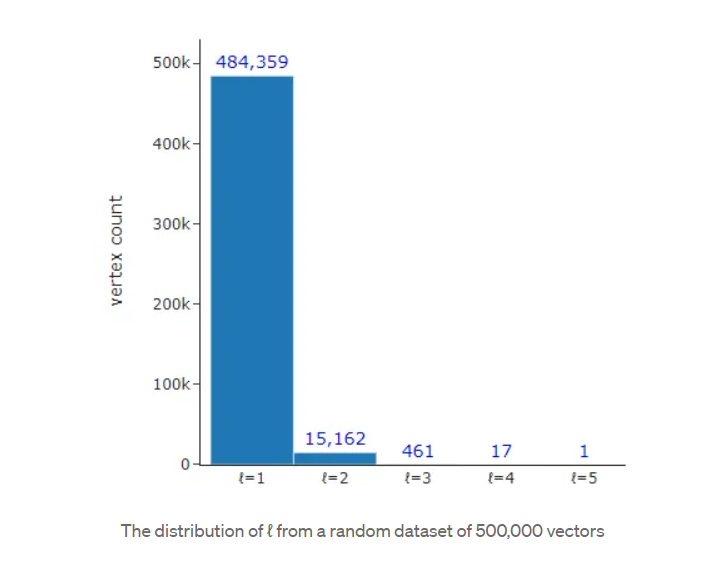


5) During the insertion process, on each level, the algorithm greedily explores the neighborhood of vertices and maintains a dynamic list of currently found nearest neighbors of the newly inserted vertex.

Phase 1 of insertion : Actual level >= l derived from step 4. For example, l=3, and height of HNSW is 5, Start at level 5

Insertion starts at the top level  with size of dynamic list set to 1. Pick the closest node at that level to the incoming vector, use that as an entry point to next layer below. Repeat till current level = l-1

Phase 2 of insertion

From this point onwards, the size of the dynamic list follows the value set by a parameter called efConstruction. In addition to acting as entry points to next layer beneath (if any), currently found nearest neighbours are also candidate friends, out of which M would be selected to make connections with the newly incoming vector at the current level. Repeat this step till level 0 is reached and all connections in level 0 are made



efConstruction (that sets the size of the dynamic candidate list) can be defined as the parameter that controls the number of candidate neighbors to explore. It signifies the depth of exploration during construction time.








There is also an additional heuristic used during construction. In addition to picking M as the closest neighbours at any level, the heuristic ensures that you can pick a further neighbour over a closer neighbour to the current inserted node, if it gives better overall graph connectivity

Example :

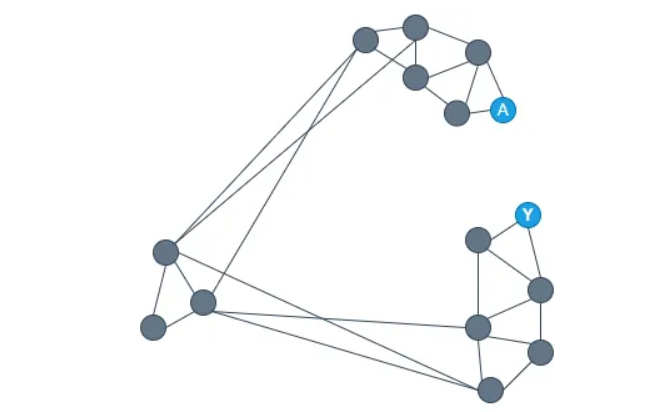

As you can see , A and Y are nearby but don't have connectivity between them which is not good, as A->Y has to take a very long path


With M=2, let's insert a new vertex N at position shown below

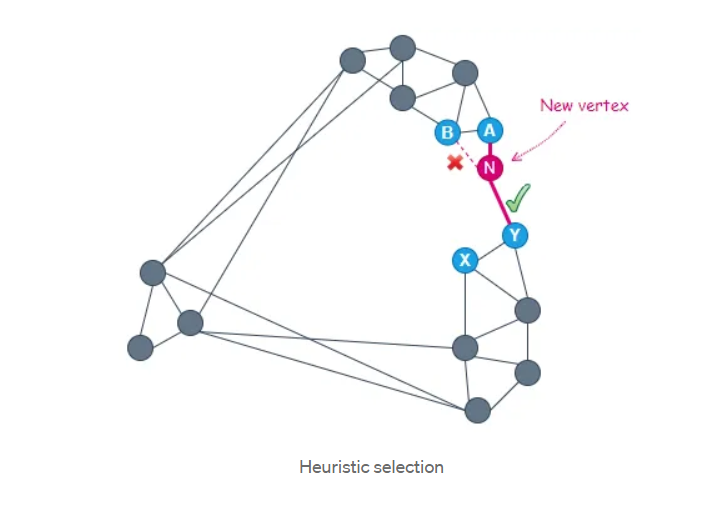

N has 4 neighbours A,B,X,Y out of which it has to choose 2 for connecting since M=2

A is closest to N, so connect A to N
The next closest is B, however Connecting B-N doesn't help bridge the gap. Heuristic wise, since existing connection B-A is smaller than candidate new connection B-N, B is skipped to connect to N, and instead Y is connected to form edge B-Y (the next closest)








Besides establishing M connections for every new vertex, to keep the small world navigability in mind, the total no of connections each vertex has is also capped to 2 * M for level 0, M for all other levels

### HNSW search

1) starts from a designated entry point at the top level. It follows the same search procedure as described by the insertion process, greedily exploring the neighborhood of vertices to find the vertex that is closest to the query vector and moves towards it

2) When it can no longer find any vertex that is closer to the query vector than itself, it then descends to the next level.

3) The search continues until the bottom level (Level 0) is reached, at which point more candidate neighbors would be explored. The size of the dynamic list of currently found nearest neighbors would then follow the value set by a parameter called efSearch


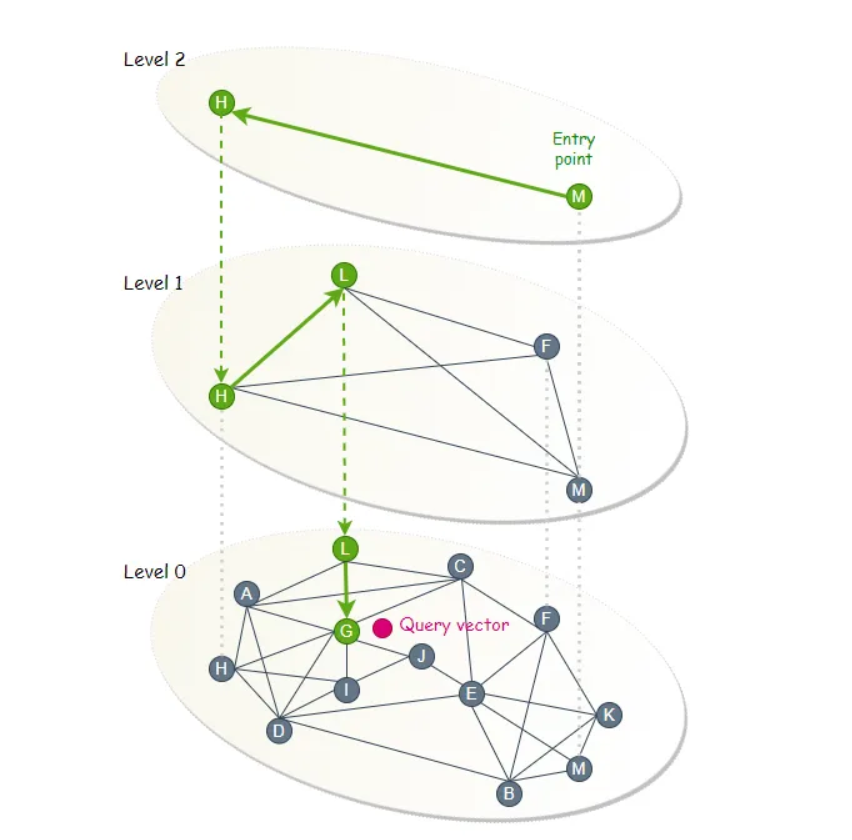


## Impact of hyperparameters M, efconstruction and efsearch



### Impact on search speed

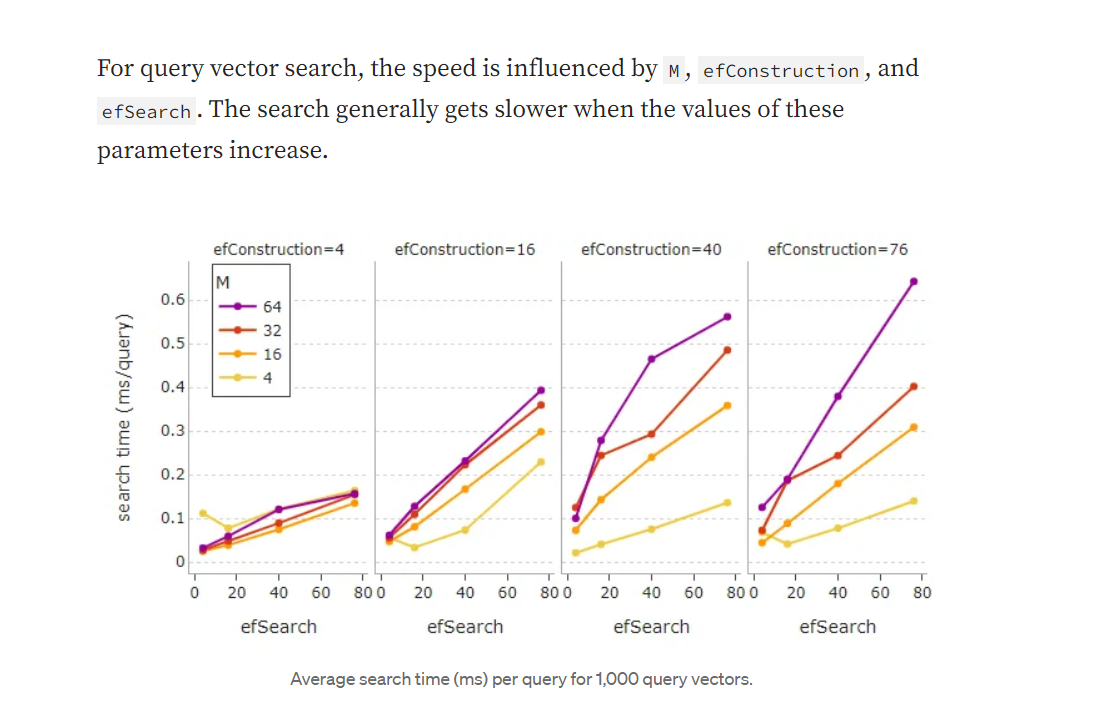

### Impact on search quality (recall)

The same parameters also affect the search quality. Higher recalls can be obtained by having larger values for M, efConstruction, or efSearch.

(So note that increasing these parameters increase quality, but also search time, so tradeoff)

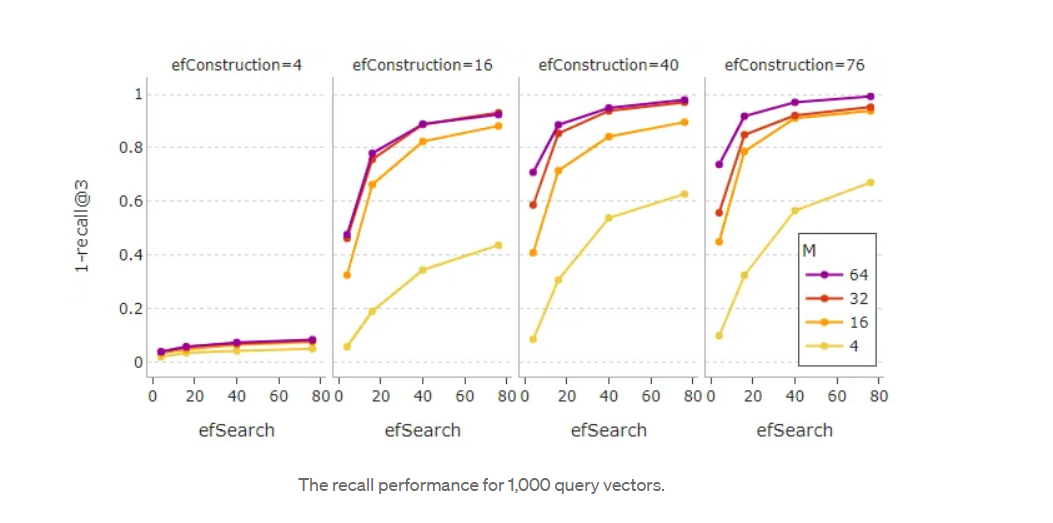


Note from plot above : If efsconstruction is very low, even if you increase efsSearch or M, it is useless
So we need a fairly high number 

efConstruction=40 together with M=32 and efSearch=16 is able to reach an impressive recall of 0.85 at a fast search speed of 0.24 ms per query.

(True answer within top 3 hits 85% of time)




the recall slowly starts to plateau after a certain point for high values of M, efSearch, and efConstruction. Also, be mindful that setting high values for M and efConstruction can cause a notably longer construction time, as portrayed below.

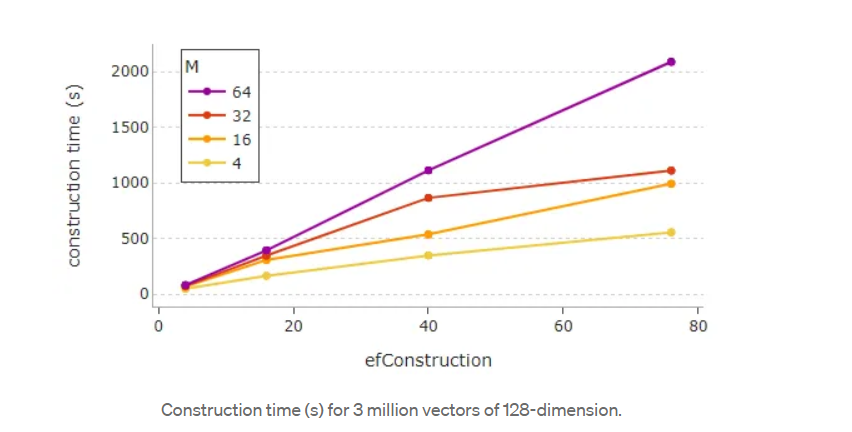

Note : Index size of HNSW (memory usage) grows linearly with M

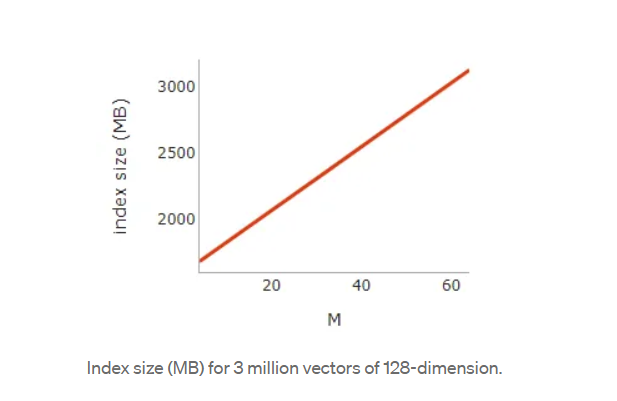


Trying to capture all the information in one plot

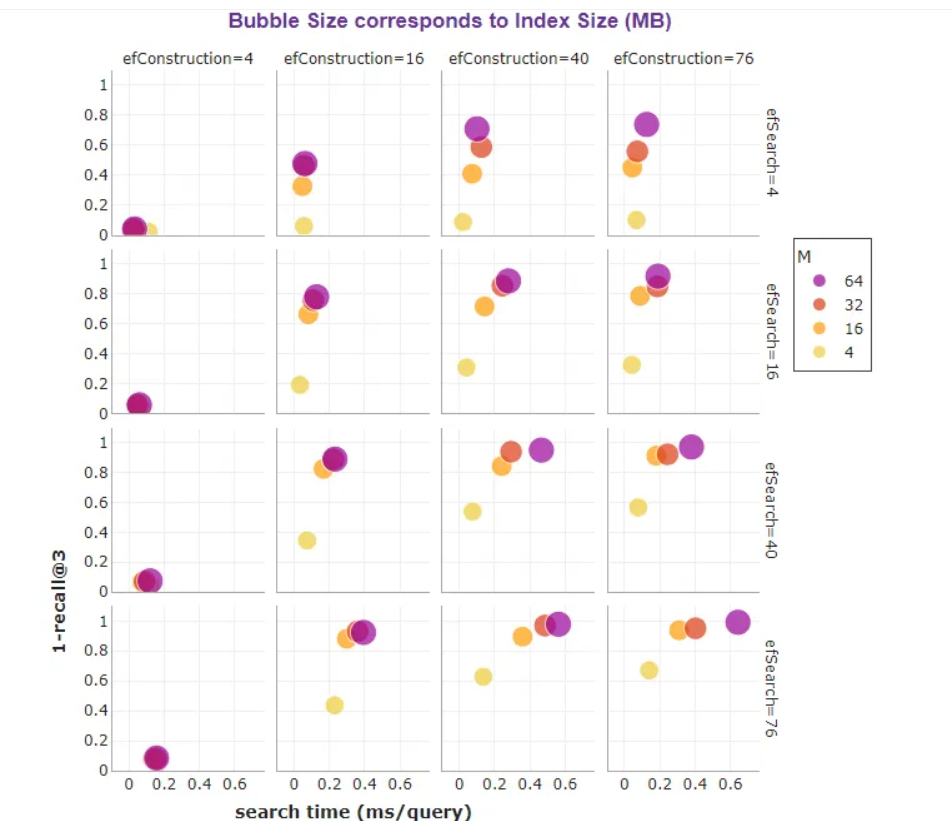

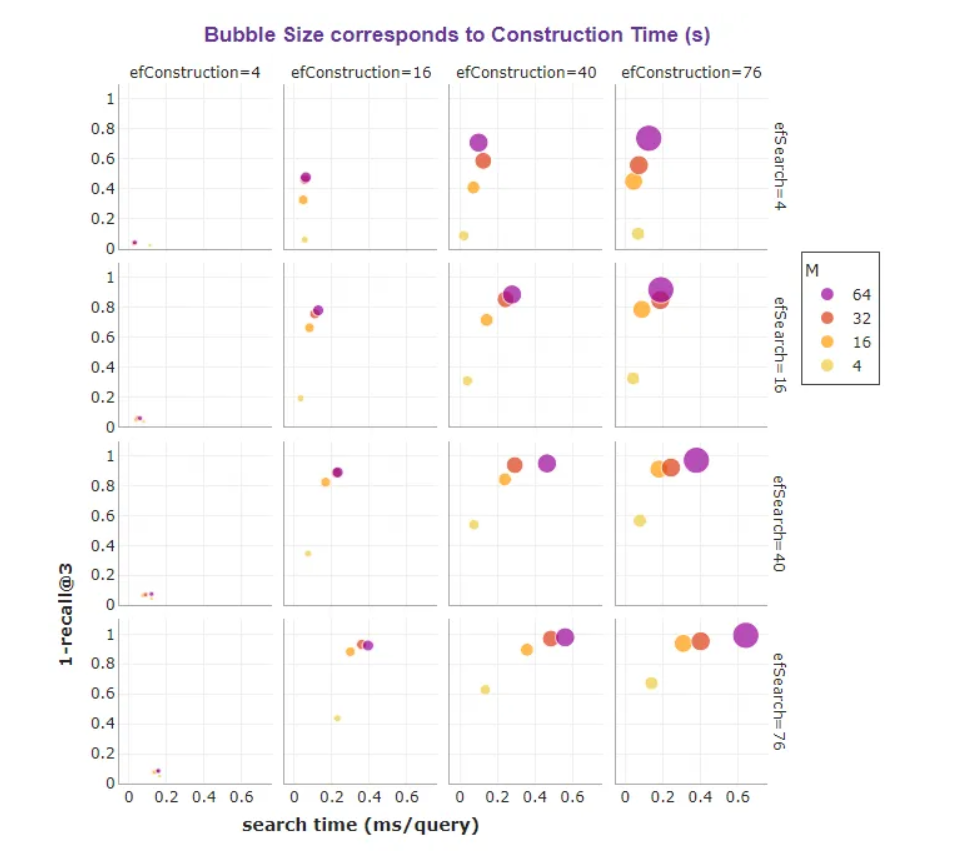

## Composite indexes with HNSW

As discussed in the vector_search introduction section, you can use other indexing methods with HNSW to form composite indexes to get even better

Specifically, HNSW can be used as a coarse quantizer, similar to IVF, to restrict teh search space to partitions, and then you could use IVFPQ as a fine quantizer



### Comparison of different composite indexes using HNSW

Candidates:

IVFPQ+HNSW
IVF+HNSW
HNSW
HNSW+PQ



IVFPQ+HNSW appeared as the champion in terms of index size or memory usage. With just 154 MB in size, it is 15 times more memory efficient than HNSW alone.

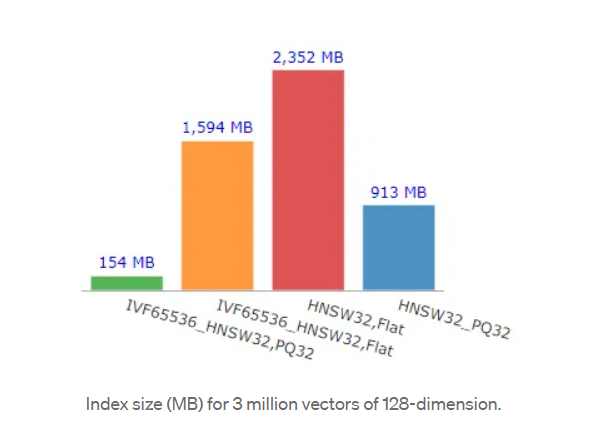

Variation of search speed and performance (recall) with nprobe, IVF parameter which says how many nearby voronoi cells you need to search in


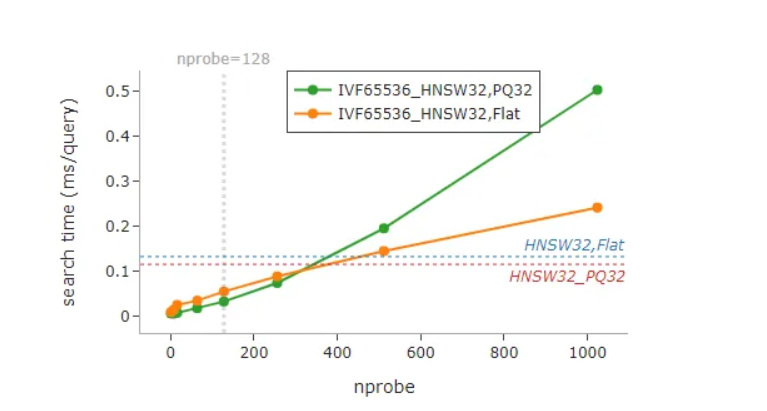


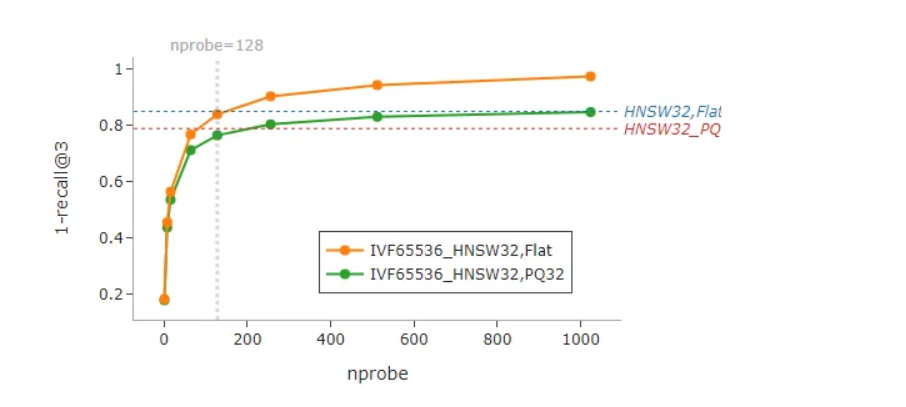


Selecting an appropriate nprobe is key to balancing the trade-offs between search speed and accuracy.


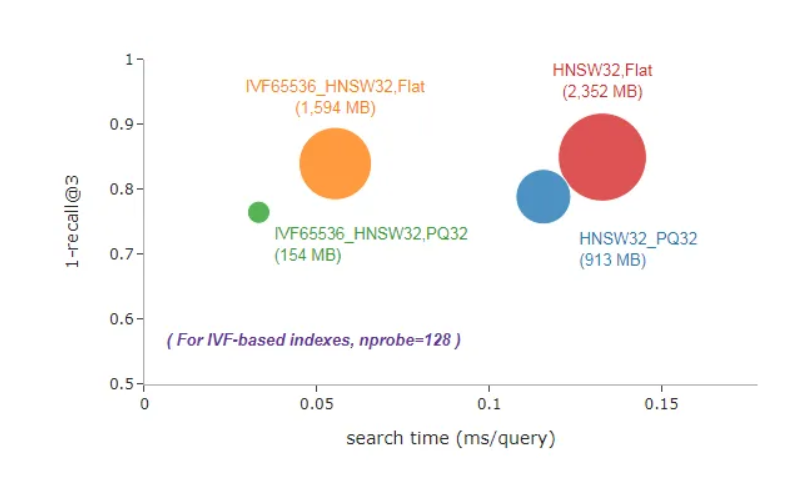

Lower bubble size - lesser memory footprint - better

### Conclusion

In terms of search speed, it can be observed that IVF-based indexes (green and orange bubbles) are leading the race. They are incredibly fast due to the non-exhaustive nature of the search, as the search is only performed on a small subset of partitions.

In terms of accuracy, HNSW (red bubble) comes first, while PQ indexes (green and blue bubbles) are lagging behind. PQ indexes are indexes with Product Quantization. They are anticipated to have lower accuracy due to the lossy compression that they make. However, their weakness is highly compensated by huge savings in memory


Clearly, IVFPQ+HNSW (green bubble) is the winner both in terms of search speed and memory efficiency. It has the smallest memory footprint (look at how tiny the green bubble is), and by using nprobe=128, it managed to achieve the fastest average search time of 0.03 ms per query, all with a good recall of 0.77.

With a good balance of speed, memory usage, and accuracy, IVFPQ+HNSW makes the best indexing approach for billion-scale similarity search.

## References

1) https://www.youtube.com/watch?v=QvKMwLjdK-s&t=546s
2) https://www.geeksforgeeks.org/skip-list/
3) https://towardsdatascience.com/ivfpq-hnsw-for-billion-scale-similarity-search-89ff2f89d90e#:~:text=Clearly%2C%20IVFPQ%2BHNSW%20(green,a%20good%20recall%20of%200.77.